In [2]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn import tree
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn import neighbors
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
-

In [4]:
df_train = pd.read_csv("titanic_train.csv") 
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
df_train = clean_data(df_train, drop_passenger_id=True)
df_train.head()

,Survived,Pclass,Fare,Sex_Val,Embarked_Val_C,Embarked_Val_Q,Embarked_Val_S,AgeFill,FamilySize
0,0,3,7.2500,1,0,0,1,22.0,1
1,1,1,71.2833,0,1,0,0,38.0,1
2,1,3,7.9250,0,0,0,1,26.0,0
3,1,1,53.1000,0,0,0,1,35.0,1
4,0,3,8.0500,1,0,0,1,35.0,0


In [6]:
#Convert the DataFrame to a numpy array:
train_data = df_train.values
train_data

array([[  0.    ,   3.    ,   7.25  , ...,   1.    ,  22.    ,   1.    ],
       [  1.    ,   1.    ,  71.2833, ...,   0.    ,  38.    ,   1.    ],
       [  1.    ,   3.    ,   7.925 , ...,   1.    ,  26.    ,   0.    ],
       ..., 
       [  0.    ,   3.    ,  23.45  , ...,   1.    ,  21.5   ,   3.    ],
       [  1.    ,   1.    ,  30.    , ...,   0.    ,  26.    ,   0.    ],
       [  0.    ,   3.    ,   7.75  , ...,   0.    ,  32.    ,   0.    ]])

In [7]:
# Training data features, skip the first column 'Survived'
X = train_data[:, 1:]
X[:5]

array([[  3.    ,   7.25  ,   1.    ,   0.    ,   0.    ,   1.    ,
         22.    ,   1.    ],
       [  1.    ,  71.2833,   0.    ,   1.    ,   0.    ,   0.    ,
         38.    ,   1.    ],
       [  3.    ,   7.925 ,   0.    ,   0.    ,   0.    ,   1.    ,
         26.    ,   0.    ],
       [  1.    ,  53.1   ,   0.    ,   0.    ,   0.    ,   1.    ,
         35.    ,   1.    ],
       [  3.    ,   8.05  ,   1.    ,   0.    ,   0.    ,   1.    ,
         35.    ,   0.    ]])

In [8]:
# 'Survived' column values
y = train_data[:, 0]
y[:5]

array([ 0.,  1.,  1.,  1.,  0.])

In [21]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, y)
pred_target = clf.predict(X)

print(metrics.precision_score(y, pred_target, average='weighted'))
print(metrics.recall_score(y, pred_target, average='weighted'))
print(metrics.f1_score(y, pred_target, average='weighted'))
print(metrics.accuracy_score(y, pred_target))
print(metrics.precision_recall_fscore_support(y, pred_target))


0.863455328965
0.864197530864
0.863731634148
0.864197530864
(array([ 0.88926746,  0.81578947]), array([ 0.90311419,  0.79233227]), array([ 0.89613734,  0.80388979]), array([578, 313]))


In [14]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.10, 
                                                    random_state=0)

In [15]:
train_pred = clf.predict(train_x)
test_pred = clf.predict(test_x)

In [16]:
print(metrics.accuracy_score(train_y, train_pred))
print(metrics.accuracy_score(test_y, test_pred))

0.863920099875
0.866666666667


In [17]:
cm = confusion_matrix(test_y, test_pred)
print(cm)

[[46  6]
 [ 6 32]]


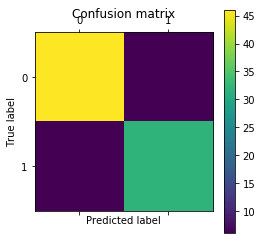

In [18]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(test_y, 
                            test_pred, 
                            target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.88      0.88      0.88        52
    Survived       0.84      0.84      0.84        38

 avg / total       0.87      0.87      0.87        90



In [20]:
# cross validation
scores = cross_validation.cross_val_score(clf, X, y, cv=5)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.04)
